# Inference and Decisions

我们一直在谈论概率，并且有一些工具可以用来操纵分布和估计参数。我们如何将其转化为决策？在这里，我们将讨论一些可能有助于为该决定提供信息的措施。

<hr style="border:2px solid blue"> </hr>

## Classification

在上一节中，我们举例说明了确定疾病状态的测试。我们接受了测试并发现了一个阳性结果，这导致我们真正被感染的可能性为 79%。很有可能，我们患有这种疾病。我们是否足够确定我们会寻求适当的治疗，或者我们可能需要第二意见？有第二次测试吗？我们是否简单地进行两次测试并将结果结合起来？当我们建立一个计算模型时，我们会反复问这个问题，并且必须做出决定，我们是继续当前的方向，还是从我们来的地方走。做出错误选择的后果往往是不对称的。我们的总体目标不只是避免错误，而是要考虑决策及犯错的后果。

在概率方面表达这一点，就是 对于二元决策，我们的目标是：

$$\text{argmin } p(mistake) = \sum_{i=1}^k p(x_{k \notin j},C_k)$$ 其中 j/k 是类别标签

## Rejection regions or decision boundaries

在我们的决定中，我们可能会选择一个区域包含在一个或另一个类别中，例如，我们可能决定疾病分类中的最佳边界为 $p(disease|+test)>75%$。请注意，决策边界应划分空间。带决策边界表示：

$$\text{argmin } p(mistake) = \int_{\mathbb{R_1}} p(x,C_2) dx + \int_{\mathbb{R_2}} p(x,C_1) dx$$


回到抛硬币实验，试验一个硬币掷1000次，执行1000次试验，然后统计每次试验里正面朝上的比例，然后绘图如下。

bounds are:
[0.4, 0.65]


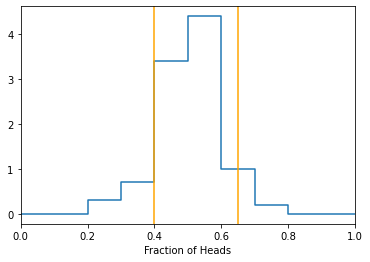

In [1]:
import numpy as np
import random as random
import matplotlib.pyplot as plt

# define an experiment as flipping Ncoins
# we will repeat the experiment Ntrials times
# for each experiment, we record the fraction of heads(1's) observed

def do_one_trial(pheads=0.5, Ncoins=10):
    coin = [1,0] #H=1, T=0
    total_flips = 1000 
    toss_results = random.choices(coin,k=Ncoins,weights=[pheads,1-pheads])
    fraction_successes = float(sum(toss_results)/Ncoins) # success = head
    return fraction_successes

def do_many_trials(pheads=0.5, Ntrials=1000, Ncoins=20):
    resultarr = []
    for i in range(0, Ntrials):
        resultarr.append(do_one_trial(pheads=pheads, Ncoins=Ncoins))
    return resultarr

# looking to get the bounds of the rejection region for plotting
def get_thresh_2tail(trial_data, significance=.1):
    sorted_results = np.array(sorted(trial_data))
    twotailedsig = significance/2.
    # sum from left to right to find left most bound
    for val in sorted_results:
        integral = float(len(sorted_results[sorted_results<val]))/len(sorted_results)
        if integral > twotailedsig:
            lowerbound = val
            break
    # sum from right to left to find right most bound
    for val in sorted_results[::-1]:
        integral = float(len(sorted_results[sorted_results>val]))/len(sorted_results)
        if integral > twotailedsig:
            upperbound = val
            break
    return lowerbound, upperbound

coin_experiment_data = do_many_trials(pheads=0.5, Ntrials=100, Ncoins=20)
lowerbound, upperbound = get_thresh_2tail(coin_experiment_data, significance=0.1)

# plot data with rejection regions
hist, bins = np.histogram(coin_experiment_data, bins = np.linspace(0,1,11), density=True)
hist = np.concatenate([hist,[0.]])
plt.plot(bins, hist, drawstyle='steps-post')
plt.xlabel('Fraction of Heads')
plt.axvline(lowerbound, color='orange')
plt.axvline(upperbound, color='orange')
plt.xlim(0, 1)

print("bounds are:")
print([lowerbound, upperbound])
plt.show()

可以看到大部分时候还是50%概率，不过也有少于或多于50%的情况。现在的问题是我们怎么知道这是一个公平的硬币，我们怎么基于这些信息做决策，比如扔掉这个硬币。

答案是我们可以设置一个我们做决定的区域，比如我们认为小于0.4或大于0.65的时候，硬币是不公平的。我们知道当我们这么做的时候，我们就有一定概率犯错误，所以我们要考虑犯错的后果。

我们引入了损失函数的概念。损失函数（也称为成本函数或作为正值的效用函数）是我们创建的一个函数，它以最小化错误为目标，能考虑不同错误后果的差异。现在的目标是最小化平均损失：

$$E[loss] = \sum_k \sum_j \int_{\mathbb{R_j}} L_{kj}p(x,C_k) dx$$

### Loss functions

损失函数是为了将我们的目标与惩罚相匹配而创建的函数，以将我们的算法引导到有益的区域。例如，考虑以下损失函数：

$$\begin{matrix} & \text{disease} & \text{no disease} \\ \text{disease} & 0 & 100 \\\text{no disease} & 1 & 0 \end{matrix}$$

在这里，我们为正确响应分配零损失，为我们预测“没有疾病”但真实状态为“疾病”的情况分配 1 损失，最后，为错误预测“疾病”的情况分配 100 损失。这里的损失函数隐含地惩罚误报而不是漏报（见最后的混淆矩阵）。

$$L(\theta,a) = 
\begin{cases}
    0, \text{for {(predict disease, actual disease),(predict no disease, actual no disease)}} \\
    1, \text{for predict no disease, actual disease} \\
    100, \text{for predict disease, actual no disease} \\
\end{cases}
$$


### Cross Entropy Loss

任何是数据的经验分布和模型的概率分布之间的负对数似然的损失函数都是交叉熵损失。

通常，当人们谈论交叉熵损失时，其含义是针对二元分类的。事实上，交叉熵损失，也称为对数损失，是二元分类任务的首选函数，它是伯努利试验的对数似然。

$$-y_i ln(\hat{\theta}_i) - (1-y_i) ln (1-\hat{\theta}_i)$$

交叉熵损失很好，因为它会严重惩罚非常错误的结果。在这种情况下，真正的标签是 \\(y_i\\) 的，而我们的预测是相关的概率（\\(\hat{\theta}_i\\) 的）。请注意，交叉熵损失没有“奖励”，当输出正确时，您能做的最好是 0。

In [123]:
import numpy as np
predictions = np.array([[0.95,0.05],
                        [0.15,0.85],
                        [0.75,0.25],
                        [0.04,0.96]]) #predictions are A,B,B,A
targets = np.array([[1,0],
                    [1,0],
                    [0,1],
                   [0,1]]) #correct classes are A,A,B,B

epsilon=1e-10 # avoid log of zero
predictions = np.clip(predictions, epsilon, 1. - epsilon)
N = predictions.shape[0]
x = targets * np.log(predictions+1e-7)
print("Penalties for each prediction")
print(x)
ce_loss = -np.sum(x)/N
print ("Total cross entropy loss is: " + str(ce_loss))


Penalties for each prediction
[[-0.05129319 -0.        ]
 [-1.89711932 -0.        ]
 [-0.         -1.38629396]
 [-0.         -0.04082189]]
Total cross entropy loss is: 0.8438820897043499


请注意，这可以很容易地扩展到多个类别的情况。

### Categorical cross entropy loss

$$\text{CE loss }= - \sum_{i=1}^I \sum_{k=1}^K \mathbb{1}_{y_i = k}log p(y_i = k | x_i,\theta)$$

这看起来完全不同，但理解这些术语将很快帮助熟悉设置。CE 损失是分配给预测类别的概率之和。 \\(\mathbb{1}\\) 是一个指示函数，用于确定哪个类是正确的类，而 \\(p(y_i = k | x_i,\theta)\\) 是给定正确类的可能性数据。在两个类别的情况下，这简化为上面的交叉熵情况。

### Other classification loss functions

**Focal loss** 是一种修正损失，试图突出错误分类样本与正确分类样本的损失。

$$FL = - \sum_{i=1}^{C=2}(1-\hat{\theta}_i)^\gamma t_i log(\hat{\theta}_i)$$ 
其中 \\((1-\hat{\theta}_i)^\gamma\\) 调节损失。随着正确响应的分配概率趋向于 1，对损失的贡献会更快地变为 0。

**Hinge loss** 是最大边距分类器。基本上，这种损失旨在使分类更加确定事件。正确作业的分数应比不正确作业的分数总和多出一定幅度。

$$HL = \sum_{j \ne y_i} max(0,s_j-s_{y_i}+1)$$

### Continuous response

在连续响应中，拟合优度度量是距离的某个函数。

#### Mean squared error 

均方误差 MSE 定义为 

$$MSE = \frac{1}{N} \sum_{i=1}^N (y_i - \hat{y_i})^2$$

作为损失函数，它具有许多不错的特征，包括基于与预测和数学属性的距离进行惩罚，例如它是可微的并且总是有一个单一的解。 MSE 对异常值敏感，即它对异常值不稳健。

#### Mean absolute error 

平均绝对误差 MAE 定义为 

$$MAE = \frac{1}{N} \sum_{i=1}^N |y_i - \hat{y_i}|$$

与 MSE 一样，MAE 返回误差均值，但需要计算工具来处理缺少微分的问题。 MAE 对 oulier 的敏感性低于 MSE，但是，不能保证唯一的解。

#### L1 and L2 loss

L1 损失是绝对差的总和，也称为最小绝对偏差 (LAD) 方法。 \\(L_1 = N \ast MAE\\)。

L2 损失是 $N \ast MSE$ 也称为最小二乘误差或 LSE。

#### Regularization 

正则化是一种通过向回归系数的总和添加惩罚项来防止过度拟合的技术。例如：

$$argmin LSE + \lambda \sum_{i=1}^k|w_i|$$
其中 \\(w_i\\) 是正在学习的权重。

以上将是最小二乘法 (LASSO) 上的 L1 正则化。还有其他变化，包括 L2 正则化（岭回归），其中惩罚是平方权重，弹性网络（L1 和 L2 正则化）等。

## Confusion matrix

对于二元分类问题，我们有所谓的混淆矩阵。对于已知为 A 的类，我们预测的是 A 还是 B？该问题的结果可以总结在混淆矩阵中：


|                     | Positive Class                    | Negative Class                       |
|---------------------|-----------------------------------|--------------------------------------|
| Positive Prediction | True Positive (TP)                | False Positive (FP) **Type I error** |
| Negative Prediction | False Negative (FN) **Type II error** | True Negative (TN)              |

各单元格产生 4 种可能的情况：TP、FP、FN、TN。与这些情况相关的是边界比例：

真阳性率 (TPR)：TP/(TP+FN) -- **灵敏度**
误报率 (FPR)：FP/(FP+TN)
真负率 (TNR)：TN/(TN+FP) -- **特异性**
假阴性率 (FNR)：FN/(FN+TP)

顺便说一句，我们可以将这些映射到贝叶斯规则，其中

P(A) = Probability of Positive Class (PC)  
P(not A) = Probability of Negative Class (NC)  
P(B) = Probability of Positive Prediction (PP)  
P(not B) = Probability of Negative Prediction (NP)  

$$P(A|B) = \frac{P(B|A)*P(A)}{P(B)} = \frac{TPR*PC}{TPR*PC + FPR*NC}$$


Precision also called the Positive Predictive Value.  
$$precision = PPV = \frac{TP}{TP+FP} = \frac{TPR*PC}{PP}$$

Recall is also known as the sensitivity.  
$$recall = \frac{TP}{TP+FN}$$

$$F_1 score = \frac{precision*recall}{precision+recall}$$

Type 1 error = false positive

Type 2 error = false negative

总之，面对不确定性做出决定是一种选择。有很多方法可以说明如何做出选择。简单地说，人们可以选择最有可能正确的选项。所有的选择都具有同等的后果吗？可能不是。为了允许这种有偏错误的观点，我们引入了损失函数的概念。损失函数是我们调整算法以找到代表我们错误的现实世界后果的最佳解决方案的机会。
<hr style="border:2px solid blue"> </hr>